<a href="https://colab.research.google.com/github/Sanyukta10-09/Sanyukta-Kharug/blob/main/testing_1_2_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✨ Welcome to WeatherWise – Your Location-First Weather Advisor ✨
I will first ask for the location, and then what weather information you'd like.
Type 'exit' to quit.

🌍 Which city or location would you like the weather for? (or type 'exit' to quit):
> Plaine des roches 
🌐 Attempting to get weather data for Plaine des roches...
💬 What weather information would you like? (e.g., 'temperature tomorrow', 'rain today', 'forecast'):
> rain today 

📝 Response: 🌧️ For Plaine des Roches Village Hall, Plaines des Roches Road, Plaines des Roches VCA, North, Riviere du Rempart, 31201, Mauritius / Maurice today: Expect about 0.14mm of rain in the 3 hours around that time.
📊 Do you want to see 5-day temperature and precipitation charts? (yes/no):
> yes 
Creating charts...


<ipython-input-5-e3392beb0d52>:354: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


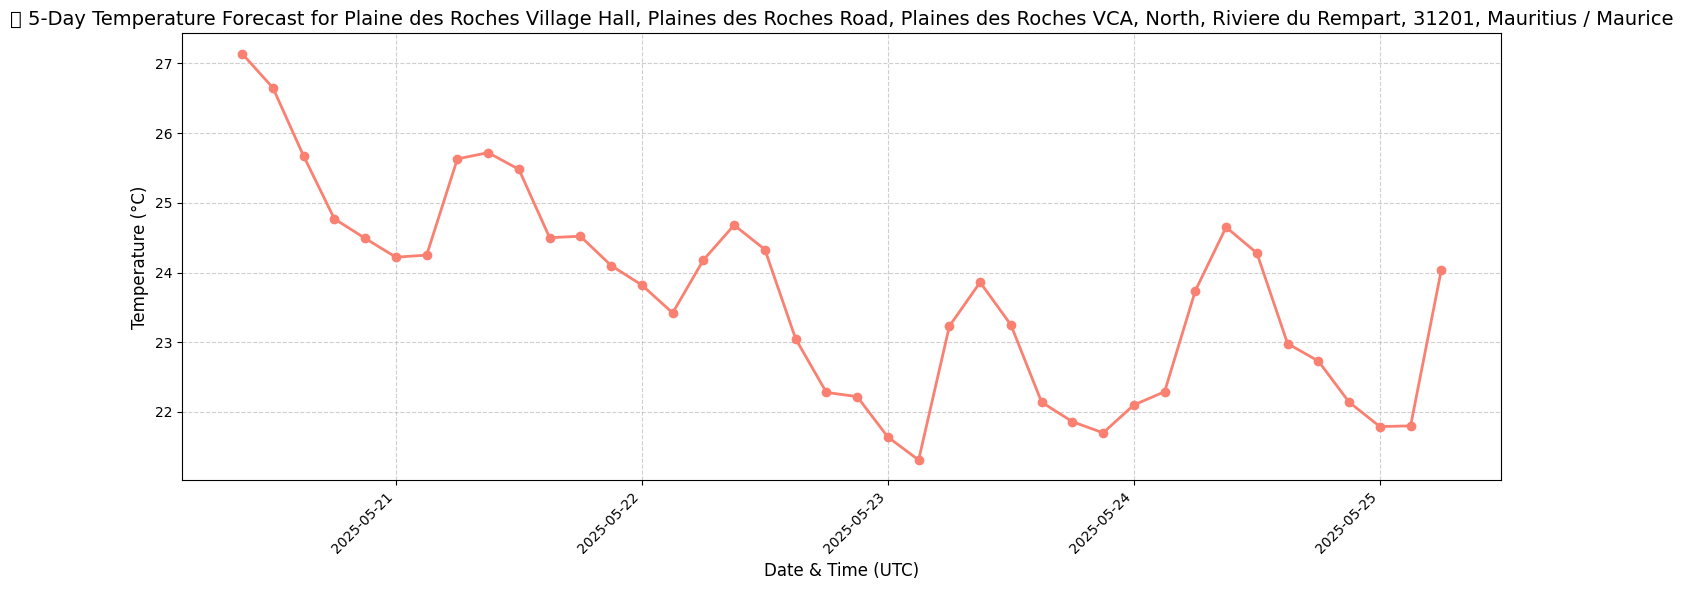

<ipython-input-5-e3392beb0d52>:381: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


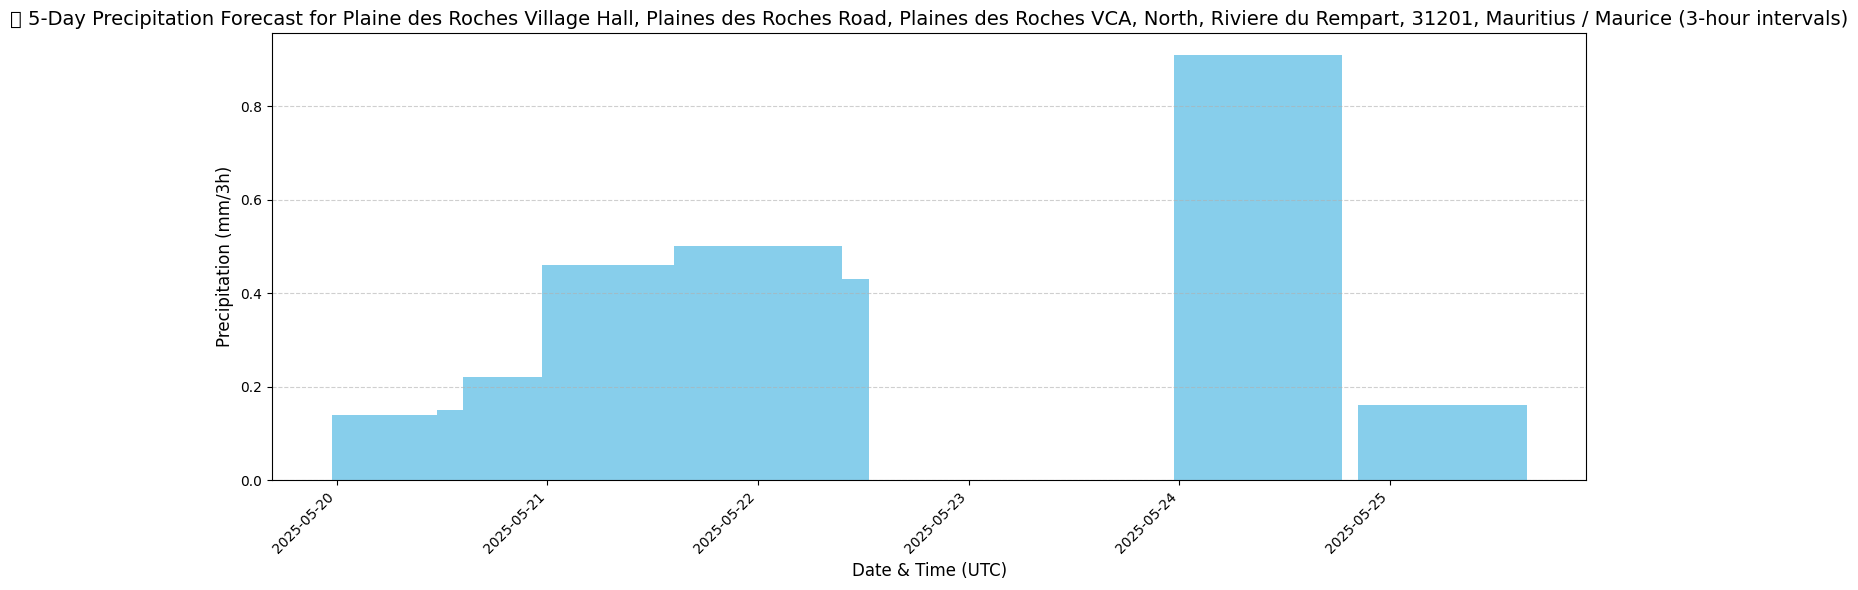


🌍 Which city or location would you like the weather for? (or type 'exit' to quit):
> 

In [ ]:
# %%
# ✅ Install required packages
!pip install requests pyinputplus matplotlib pandas geopy timezonefinder pytz

# 📚 Imports
import requests
import pyinputplus as pyip
import matplotlib.pyplot as plt
import os
from datetime import datetime
import pandas as pd
from geopy.geocoders import Nominatim
from timezonefinder import TimezoneFinder
import pytz
import re # Import regex for basic parsing

# 🔐 Prompt for OpenWeatherMap API Key
if not os.environ.get("OPENWEATHER_API_KEY"):
    api_key_input = pyip.inputStr("🔑 Please enter your OpenWeatherMap API Key:\n> ")
    os.environ["OPENWEATHER_API_KEY"] = api_key_input

# Geocoding setup for more precise location handling
geolocator = Nominatim(user_agent="weather_wise_app_location_first")
tf = TimezoneFinder()

# -----------------------------------------------
## 1. Get Weather Data
# -----------------------------------------------
def get_weather_data(location):
    """
    Retrieve 5-day weather forecast data from OpenWeatherMap API using coordinates.
    First attempts geocoding to get coordinates.
    """
    api_key = os.environ.get("OPENWEATHER_API_KEY")
    if not api_key:
        print("❗ Error: API key not found.")
        return None, "API key not found."

    # Attempt to get coordinates for the location
    try:
        geocode_location = geolocator.geocode(location)
        if not geocode_location:
            # More specific error for geocoding failure
            return None, f"Location '{location}' not found. Please check the name or try adding country/state."
        lat = geocode_location.latitude
        lon = geocode_location.longitude
        city_name = geocode_location.address # Use the name found by geocoder

    except Exception as e:
        return None, f"Geocoding Error for '{location}': {e}"

    try:
        # Use coordinates for API call for better accuracy
        url = f"http://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={api_key}&units=metric"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        weather_data = response.json()

        # Add the standardized city name to the data
        weather_data['city_name_geocoded'] = city_name

        return weather_data, None # Return data and no error
    except requests.RequestException as e:
        return None, f"OpenWeatherMap API Error: Could not retrieve data for '{city_name}'. {e}"

# -----------------------------------------------
## 2. Basic Text Parsing (Forecast Details)
# -----------------------------------------------
def parse_forecast_details(query):
    """
    Basic parsing of user query to extract date and weather attribute using keywords.
    """
    date_spec = None
    attribute = None

    q_lower = query.lower()

    # Basic date matching
    if "today" in q_lower or "now" in q_lower:
        date_spec = "today"
    elif "tomorrow" in q_lower:
        date_spec = "tomorrow"
    elif "weekend" in q_lower:
        date_spec = "weekend"
    elif "in 5 days" in q_lower or "in five days" in q_lower:
         date_spec = "in 5 days"

    # Attribute matching using keywords
    keywords = {
        "temperature": ["temperature", "temp", "hot", "cold", "warm", "chilly", "how hot", "how cold"],
        "rain": ["rain", "raining", "rainfall", "umbrella", "precipitation", "showers"],
        "humidity": ["humidity", "humid"],
        "wind": ["wind", "breeze", "windy", "how windy"],
        "condition": ["weather", "forecast", "conditions", "what's it like"],
        "sunrise_sunset": ["sunrise", "sunset", "sun up", "sun down"]
    }

    for key, words in keywords.items():
        for word in words:
            if re.search(r'\b' + re.escape(word) + r'\b', q_lower):
                attribute = key
                break
        if attribute:
            break

    # This function returns date and attribute, no location needed
    return {"date_spec": date_spec, "attribute": attribute}


# -----------------------------------------------
## Helper: Find Nearest Forecast Entry
# -----------------------------------------------
def find_nearest_forecast_entry(weather_data, target_date_spec):
    """
    Find the forecast entry closest to the specified date.
    """
    if not weather_data or "list" not in weather_data:
        return None

    forecast_list = weather_data["list"]
    now_utc = datetime.utcnow()

    if target_date_spec == "today":
        return forecast_list[0]
    elif target_date_spec == "tomorrow":
        target_time = now_utc + pd.Timedelta(days=1)
    elif target_date_spec == "weekend":
         target_time = now_utc + pd.Timedelta(days=2)
    elif target_date_spec == "in 5 days":
         target_time = now_utc + pd.Timedelta(days=5)
    else: # Default to the first entry
        return forecast_list[0]

    min_time_diff = float('inf')
    nearest_entry = None

    for entry in forecast_list:
        try:
            entry_time_utc = datetime.strptime(entry['dt_txt'], '%Y-%m-%d %H:%M:%S')
            time_diff = abs((entry_time_utc - target_time).total_seconds())

            if time_diff < min_time_diff:
                min_time_diff = time_diff
                nearest_entry = entry
        except (KeyError, ValueError, TypeError) as e:
             print(f"⚠️ Skipping forecast entry due to time parsing error: {entry.get('dt_txt')} Error: {e}")
             continue


    return nearest_entry


# -----------------------------------------------
## Helper: Get Timezone and Local Time
# -----------------------------------------------
def get_local_time_and_timezone(lat, lon):
    """
    Get the timezone name and current local time for given coordinates.
    """
    try:
        timezone_str = tf.timezone_at(lng=lon, lat=lat)
        if not timezone_str:
             return None, None, "Could not determine timezone."
        timezone = pytz.timezone(timezone_str)
        local_time = datetime.now(timezone)
        return local_time, timezone_str, None
    except Exception as e:
        return None, None, f"Timezone Error: {e}"

# -----------------------------------------------
## 3. Generate Friendly Weather Response
# -----------------------------------------------
def generate_weather_response(parsed_details, weather_data):
    """
    Generate a user-friendly weather response based on parsed forecast details and weather data.
    Uses the geocoded city name from weather_data.
    """
    date_spec = parsed_details.get("date_spec")
    attribute = parsed_details.get("attribute")
    geocoded_city_name = weather_data.get('city_name_geocoded', 'the specified location')

    if not weather_data:
        return "❗ Unable to retrieve weather data for the specified location."


    # Find the relevant forecast entry
    forecast_entry = find_nearest_forecast_entry(weather_data, date_spec)

    if not forecast_entry:
         return f"⚠️ Could not find a suitable forecast for {date_spec or 'the requested time'} in {geocoded_city_name} within the next 5 days."

    try:
        condition = forecast_entry["weather"][0]["description"]
        temp = forecast_entry["main"]["temp"]
        feels_like = forecast_entry["main"].get("feels_like")
        humidity = forecast_entry["main"]["humidity"]
        wind_speed = forecast_entry.get("wind", {}).get("speed", 0)
        rain_3h = forecast_entry.get("rain", {}).get("3h", 0)
        snow_3h = forecast_entry.get("snow", {}).get("3h", 0)

        lat = weather_data.get('city', {}).get('coord', {}).get('lat')
        lon = weather_data.get('city', {}).get('coord', {}).get('lon')

        sunrise_sunset_info = ""
        if lat is not None and lon is not None and weather_data.get('city', {}).get('sunrise') is not None:
             local_time, timezone_str, tz_error = get_local_time_and_timezone(lat, lon)
             if not tz_error and timezone_str:
                sunrise_utc = weather_data['city']['sunrise']
                sunset_utc = weather_data['city']['sunset']
                try:
                    timezone = pytz.timezone(timezone_str)
                    sunrise_local = datetime.fromtimestamp(sunrise_utc, timezone)
                    sunset_local = datetime.fromtimestamp(sunset_utc, timezone)
                    if date_spec in [None, "today"] or attribute == "sunrise_sunset":
                         sunrise_sunset_info = f" The sun rose at {sunrise_local.strftime('%H:%M')} and will set at {sunset_local.strftime('%H:%M')} today (local time)."
                    else:
                         sunrise_sunset_info = f" (Current day's sunrise/sunset: {sunrise_local.strftime('%H:%M')}/{sunset_local.strftime('%H:%M')} local time)"

                except Exception as tz_calc_error:
                     sunrise_sunset_info = f" (Could not format sunrise/sunset time: {tz_calc_error})"
             else:
                 sunrise_sunset_info = f" (Could not determine timezone for sunrise/sunset: {tz_error})"
        elif attribute == "sunrise_sunset":
            sunrise_sunset_info = " (Sunrise/sunset data not available from API for this location/time)."


        emoji_map = {
            "clear": "☀️", "cloud": "☁️", "rain": "🌧️", "drizzle": "🌧️",
            "thunderstorm": "⛈️", "snow": "❄️", "mist": "🌫️", "fog": "🌫️"
        }
        emoji = "🌡️" # Default emoji
        for key, val in emoji_map.items():
            if key in condition.lower():
                emoji = val
                break

        forecast_time_utc = datetime.strptime(forecast_entry['dt_txt'], '%Y-%m-%d %H:%M:%S')
        forecast_time_local_str = forecast_time_utc.strftime('%Y-%m-%d %H:%M UTC')
        if lat is not None and lon is not None:
             local_time_zone_str, tz_error = tf.timezone_at(lng=lon, lat=lat), None
             if local_time_zone_str and not tz_error:
                 try:
                     local_timezone = pytz.timezone(local_time_zone_str)
                     forecast_time_local = pytz.utc.localize(forecast_time_utc).astimezone(local_timezone)
                     forecast_time_local_str = forecast_time_local.strftime('%Y-%m-%d %H:%M %Z')
                 except Exception as convert_error:
                      forecast_time_local_str += f" (Timezone conversion error: {convert_error})"


        time_description = date_spec if date_spec in ["today", "tomorrow", "weekend", "in 5 days"] else f"at {forecast_time_local_str}"


        response_parts = []
        prefix = f"{emoji} For {geocoded_city_name} {time_description}:"


        if attribute == "temperature":
            response_parts.append(f"The temperature will be around {temp}°C.")
            if feels_like is not None:
                 response_parts.append(f"It will feel like {feels_like}°C.")
        elif attribute == "rain":
            if rain_3h > 0:
                 response_parts.append(f"Expect about {rain_3h}mm of rain in the 3 hours around that time.")
            elif snow_3h > 0:
                 response_parts.append(f"Expect about {snow_3h}mm of snow in the 3 hours around that time.")
            else:
                 response_parts.append("No precipitation is expected around that time.")
        elif attribute == "humidity":
            response_parts.append(f"The humidity will be around {humidity}%.")
        elif attribute == "wind":
             response_parts.append(f"Wind speeds will reach about {wind_speed} m/s.")
        elif attribute == "condition":
            response_parts.append(f"The weather condition is described as '{condition}'.")
        elif attribute == "sunrise_sunset":
             if "Sunrise/sunset data not available" not in sunrise_sunset_info or "Could not determine timezone" not in sunrise_sunset_info:
                 return f"{emoji} For {geocoded_city_name}:{sunrise_sunset_info if sunrise_sunset_info else ' Sunrise/sunset information could not be retrieved or calculated.'}"
             else:
                 response_parts.append("Sunrise/sunset information could not be retrieved for this location.")

        # Default detailed response if no specific attribute or after attribute response
        if not response_parts or (attribute and "could not be retrieved" in " ".join(response_parts).lower()):
             response_parts = []
             response_parts.append(f"It will be {condition}, with a temperature around {temp}°C.")
             if feels_like is not None:
                 response_parts.append(f"It will feel like {feels_like}°C.")
             response_parts.append(f"Humidity will be {humidity}%.")
             response_parts.append(f"Wind speeds around {wind_speed} m/s.")
             if rain_3h > 0:
                 response_parts.append(f"Rainfall of {rain_3h}mm is expected in the 3 hours around that time.")
             if snow_3h > 0:
                 response_parts.append(f"Snowfall of {snow_3h}mm is expected in the 3 hours around that time.")

             if sunrise_sunset_info and date_spec in [None, "today"] and "Could not determine timezone" not in sunrise_sunset_info and "Sunrise/sunset data not available" not in sunrise_sunset_info:
                  response_parts.append(sunrise_sunset_info)


        full_response = prefix + " " + " ".join([part for part in response_parts if part])
        return full_response.strip()

    except Exception as e:
        return f"⚠️ An internal error occurred while generating the weather summary: {e}"

# -----------------------------------------------
## Helper: Prepare Data for Visualisation
# -----------------------------------------------
def prepare_viz_data(weather_data):
    """
    Prepare temperature and precipitation data from weather_data for plotting.
    Returns a pandas DataFrame.
    """
    if not weather_data or "list" not in weather_data:
        print("❗ No data to prepare for visualization.")
        return pd.DataFrame()

    data_list = []
    for entry in weather_data['list']:
        try:
            entry_time_utc = datetime.strptime(entry['dt_txt'], '%Y-%m-%d %H:%M:%S')
            data_list.append({
                'time_utc': entry_time_utc,
                'temperature': entry['main']['temp'],
                'rain_3h': entry.get('rain', {}).get('3h', 0),
                'snow_3h': entry.get('snow', {}).get('3h', 0),
                'condition': entry['weather'][0]['description']
            })
        except (KeyError, ValueError, TypeError) as e:
             print(f"⚠️ Skipping malformed weather entry: {entry.get('dt_txt')} Error: {e}")
             continue


    df = pd.DataFrame(data_list)
    if not df.empty:
        df = df.set_index('time_utc')
    return df

# -----------------------------------------------
## 4. Visualisation: Temperature Forecast (5 Days)
# -----------------------------------------------
def create_temperature_visualisation(df, city_name, output_type='display'):
    """
    Plot temperature forecast.
    """
    if df.empty:
         print("❗ No data to plot temperature.")
         return None

    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['temperature'], marker='o', linestyle='-', linewidth=2, color='salmon')
    plt.title(f"🌡️ 5-Day Temperature Forecast for {city_name}", fontsize=14)
    plt.xlabel("Date & Time (UTC)", fontsize=12)
    plt.ylabel("Temperature (°C)", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    if output_type == 'figure':
        return plt
    else:
        plt.show()

# -----------------------------------------------
## 5. Visualisation: Precipitation Forecast (5 Days)
# -----------------------------------------------
def create_precipitation_visualisation(df, city_name, output_type='display'):
    """
    Plot precipitation forecast (rain + snow).
    """
    if df.empty:
         print("❗ No data to plot precipitation.")
         return None

    df['precipitation_3h'] = df['rain_3h'] + df['snow_3h']

    plt.figure(figsize=(14, 6))
    plt.bar(df.index, df['precipitation_3h'], color='skyblue')
    plt.title(f"🌧️ 5-Day Precipitation Forecast for {city_name} (3-hour intervals)", fontsize=14)
    plt.xlabel("Date & Time (UTC)", fontsize=12)
    plt.ylabel("Precipitation (mm/3h)", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    if output_type == 'figure':
        return plt
    else:
        plt.show()

# -----------------------------------------------
## 6. Main Application Chat Loop
# -----------------------------------------------
def main():
    print("✨ Welcome to WeatherWise – Your Location-First Weather Advisor ✨")
    print("I will first ask for the location, and then what weather information you'd like.")
    print("Type 'exit' to quit.")

    while True:
        # Ask for the location first
        location_query = pyip.inputStr("\n🌍 Which city or location would you like the weather for? (or type 'exit' to quit):\n> ")
        if location_query.lower() in ["exit", "quit", "bye"]:
            print("👋 Goodbye! Stay weather-wise!")
            break

        # Ensure a location was provided
        if not location_query.strip(): # Use strip() to check for empty string after whitespace removal
             print("❗ No location provided. Please try again or type 'exit'.")
             continue

        print(f"🌐 Attempting to get weather data for {location_query}...")
        # Use get_weather_data which handles geocoding
        weather_data, error = get_weather_data(location_query)

        if error:
            print(f"❗ Error fetching data: {error}")
            continue

        # Now ask for the forecast details (date and attribute)
        query = pyip.inputStr("💬 What weather information would you like? (e.g., 'temperature tomorrow', 'rain today', 'forecast'):\n> ")
        # Parse this query for date and attribute using the basic parser
        parsed_details = parse_forecast_details(query)

        # Generate and print the weather response
        # Pass the parsed_details (date/attribute) and the weather data (containing geocoded city name)
        response = generate_weather_response(parsed_details, weather_data)
        print("\n📝 Response:", response)

        # Offer visualizations if data was successful
        if weather_data:
            show_viz = pyip.inputYesNo("📊 Do you want to see 5-day temperature and precipitation charts? (yes/no):\n> ")
            if show_viz == "yes":
                print("Creating charts...")
                viz_df = prepare_viz_data(weather_data)
                geocoded_city = weather_data.get('city_name_geocoded', location_query)

                if not viz_df.empty:
                     create_temperature_visualisation(viz_df, geocoded_city)
                     create_precipitation_visualisation(viz_df, geocoded_city)
                else:
                     print("❗ Not enough data available to create charts.")


# -----------------------------------------------
## Run the Application
# -----------------------------------------------
if __name__ == "__main__": # Corrected the typo from _name_ to __name__
    main()